#### Preamble

In [18]:
## Misc
import pandas as pd
import sys 
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('..')

## Plotting packages
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "plotly_white"

## Modelling
### torch
torch.manual_seed(101)
import torch.nn as nn
import torch
from torch.utils.data import DataLoader

## local
from models import AR_Net, AR
#from models.LSTM import ShallowRegressionLSTM
from utils.losses import censored_poisson_negative_log_likelihood
from utils.dataloader import cyclical_encode

## Predicing using covariates (hour and week variable) at time t 

#### Function to load datasets

In [72]:
def create_dataset(target, forecast_lead, add_month=True, add_hour=True, add_day_of_week=True, add_year=True, train_start='2016-07-01 00:00:00', 
                   train_end = '2017-07-01 00:00:00', test_start='2017-07-01 00:00:30', test_end='2017-08-01 00:00:00', is_censored = 'False',
                   multiple_stations = False):
    
    ## Function to load data sets, add covariates and split into training and test set. Has option to censor the input data (arg. is_censored) and 
    ## has option to use several stations to predict demand of one station (arg. multiple_stations)

    ## Output: training set, test set, list of explanatory variables (features) and list of targets (target)
    
    ## TODO: add option for validation set

    target_var = target

    if (is_censored == True):
        df = pd.read_csv('../data/charging_session_count_1_to_30_censored_mask.csv', parse_dates=['Period'])
        df_test = df.copy()

        if (multiple_stations == True):
            
            ## keep data from other stations, the period and threshold tau for target variable
            features = [v for v in df_test.columns if target + '_TAU' in v]
            other_stations = [v for v in df_test.columns if '_TAU' not in v]
            features.extend(other_stations)

            df_test = df_test[features]

            ## Remove tau so it isnt and input feature
            features.remove(target + '_TAU')

        else:
            features = [v for v in df_test.columns if target in v]
            features.append('Period')
            df_test = df_test[features]

            print(features)
            ## Remove tau so it isnt and input feature
            features.remove(target + '_TAU')

    else:
        ## keep everything from input dataframe
        df = pd.read_csv('../data/charging_session_count_1_to_30.csv', parse_dates=['Period'])
        df_test = df.copy()
        features = df_test.columns.values

        if (multiple_stations == False):
            ## Keep only data from target station and the period 
            features = [station for station in df_test.columns if target in station]
            features.append('Period')
            df_test = df_test[features]

   

    if (type(train_end) != int):
        train_start = df_test[df_test['Period'] == train_start].index.values[0]
        train_end = df_test[df_test['Period'] == train_end].index.values[0]
        test_start = df_test[df_test['Period'] == test_start].index.values[0]
        test_end = df_test[df_test['Period'] == test_end].index.values[0]

    #  Create target variable. We might have more targets if we're running 
    # multivariate models
    #features = list(df.columns.difference(['BRYANT', 'CAMBRIDGE', 'HAMILTON', 'HIGH', 'MPL', 'RINCONADA', 'TED']))
    #features = list(df.columns.difference([target_var]))
    
    forecast_lead = 24


    if isinstance(target_var, list):
        target = [f"{var}_lead{forecast_lead}" for var in target_var]
    else:
        target = f"{target_var}_lead{forecast_lead}"

    new_cols = []
    if add_month:
        df_test['month'] = df.Period.dt.month
        df_test, new_cols = cyclical_encode(df_test, 'month', 12)
        features.extend(new_cols)
        #features = features + new_cols
    if add_day_of_week:
        df_test['dayofweek'] = df.Period.dt.dayofweek
        df_test, new_cols = cyclical_encode(df_test, 'dayofweek', 7)
        features.extend(new_cols)
        #features = features + new_cols
    if add_hour:
        df_test['hour'] = df.Period.dt.hour
        df_test, new_cols = cyclical_encode(df_test, 'hour', 24)
        features.extend(new_cols)
        #features = features + new_cols
    if add_year:
        df_test['year'] = df.Period.dt.year - df.Period.dt.year.min()
        features.append('year')

    df_test[target] = df[target_var].shift(-forecast_lead)
    df_test = df_test.iloc[:-forecast_lead]

    ## Create train/test set
    df_train = df_test.loc[train_start:train_end].copy()
    df_test = df_test.loc[test_start:test_end].copy()

    features.remove('Period')

    #print("Test set fraction:", len(df_test) / len(df_train))
    return df_train, df_test, features, target



#### Dataloader classes censored and uncensored modelling

In [8]:
from torch.utils.data import Dataset

class SequenceDatasetCensored(Dataset):
    ## Class to retrieve time series elements appropirately with CENSORED target variable y

    def __init__(self, dataframe, target, features, threshold, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()
        self.tau = torch.tensor(dataframe[threshold].values).float()
        
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i):
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i], self.tau[i]
    
class SequenceDataset(Dataset):
    ## Class to retrieve time series elements appropirately with UNCENSORED target variable y

    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()
        
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i):
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

#### Test data loader and data set classes

In [114]:
TRAIN_START = '2016-07-01 00:00:00'
TRAIN_END = '2016-08-01 00:00:00'
TEST_START = '2016-08-01 00:30:00'
TEST_END = '2016-08-08 00:00:00'

batch_size = 4
sequence_length = 72
target = 'WEBSTER'
threshold = 'WEBSTER_TAU'

df_train, df_test, features, target = create_dataset(
    target = 'WEBSTER',
    forecast_lead = 24,
    add_month = True, add_hour = True, add_day_of_week = True, add_year = True,
    train_start = TRAIN_START, train_end = TRAIN_END, test_start = TEST_START, test_end = TEST_END,
    is_censored = True, multiple_stations=False)


train_dataset = SequenceDatasetCensored(
    df_train,
    target=target,
    features=features,
    threshold=threshold,
    sequence_length=sequence_length
)

test_dataset = SequenceDatasetCensored(
    df_test,
    target=target,
    features=features,
    threshold=threshold,
    sequence_length=sequence_length
)

'''
train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)

test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)'''

## Use pytorch dataload to sequentially order data using the defined dataset classes
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y, *tau = next(iter(train_loader))
#X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)
#print("Threshold shape:", tau.shape)

print(X[1,11,:])
print(y[1])
#print(tau[1])
print(target)
print(features)

['WEBSTER', 'WEBSTER_TAU', 'Period']
Features shape: torch.Size([4, 72, 8])
Target shape: torch.Size([4])
tensor([ 4.0000, -0.5000, -0.8660,  0.7818,  0.6235, -0.8660, -0.5000,  5.0000])
tensor(4.)
WEBSTER_lead24
['WEBSTER', 'month_sin', 'month_cos', 'dayofweek_sin', 'dayofweek_cos', 'hour_sin', 'hour_cos', 'year']


#### Training and test loops for CENSORED data. TODO: add validation loop

In [9]:
import torch.nn.functional as F

### Training and test function for censored data 
def train_model_censored(data_loader, model, loss_function, optimizer, verbose=True):
    num_batches = len(data_loader)
    total_loss = 0
    total_mse_loss = 0
    model.train()
    
    for X, y, tau in data_loader:
        output = model(X)

        loss = loss_function(output, y, tau)
        total_mse_loss += F.mse_loss(output, y).detach().numpy()


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    avg_mse_loss = total_mse_loss / num_batches
    if verbose:
        print(f"Train loss: {avg_loss}")
    return avg_loss, avg_mse_loss

def test_model_censored(data_loader, model, loss_function, verbose=True):
    num_batches = len(data_loader)
    total_loss = 0
    total_mse_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y, tau in data_loader:
            output = model(X)
            total_loss += loss_function(output, y, tau).item()
            total_mse_loss += F.mse_loss(output, y).detach().numpy()

    avg_loss = total_loss / num_batches
    avg_mse_loss = total_mse_loss / num_batches
    if verbose:
        print(f"Test loss: {avg_loss}")
    return avg_loss, avg_mse_loss

#### Training and test loops for UNCENSORED data. TODO: add validation loop

In [10]:
### Training and test function for uncensored data 
def train_model(data_loader, model, loss_function, optimizer, verbose=True):
    num_batches = len(data_loader)
    total_loss = 0
    total_mse_loss = 0
    model.train()
    
    for X, y, *tau in data_loader:
        output = model(X)
        loss = loss_function(output, y)
        total_mse_loss += F.mse_loss(output, y).detach().numpy()


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    avg_mse_loss = total_mse_loss / num_batches
    if verbose:
        print(f"Train loss: {avg_loss}")
    return avg_loss, avg_mse_loss

def test_model(data_loader, model, loss_function, verbose=True):
    num_batches = len(data_loader)
    total_loss = 0
    total_mse_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y, *tau in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()
            total_mse_loss += F.mse_loss(output, y).detach().numpy()

    avg_loss = total_loss / num_batches
    avg_mse_loss = total_mse_loss / num_batches
    if verbose:
        print(f"Test loss: {avg_loss}")
    return avg_loss, avg_mse_loss

#### Functions to predict CENSORED and UNCENSORED data

In [11]:
def predict_censored(data_loader, model):
    ## Input: data loader object and trained model

    ## Output: predictions on unseen data

    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, y_out, tau in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    
    return output

In [12]:
def predict(data_loader, model):
    ## Input: data loader object and trained model

    ## Output: predictions on unseen data

    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    
    return output

# Uncensored experiments

### AR

In [140]:
batch_size = 4
sequence_length = 72
target = 'WEBSTER'
threshold = 'WEBSTER_TAU'

TRAIN_START = '2016-07-01 00:00:00'
TRAIN_END = '2016-08-01 00:00:00'
TEST_START = '2016-08-01 00:30:00'
TEST_END = '2016-08-08 00:00:00'


df_train, df_test, features, target = create_dataset(
    target = target,
    forecast_lead = 24,
    add_month = True, add_hour = True, add_day_of_week = True, add_year = True,
    train_start = TRAIN_START, train_end = TRAIN_END, test_start = TEST_START, test_end = TEST_END,
    is_censored = False, multiple_stations=False)

In [141]:
train_dataset_ar = SequenceDataset(
    df_train,
    target=target,
    features=['WEBSTER'],
    sequence_length=sequence_length
)
test_dataset_ar = SequenceDataset(
    df_test,
    target=target,
    features=['WEBSTER'],
    sequence_length=sequence_length
)

train_loader_ar = DataLoader(train_dataset_ar, batch_size=batch_size, shuffle=True)
test_loader_ar = DataLoader(test_dataset_ar, batch_size=batch_size, shuffle=False)


model_ar = AR(sequence_length, 1)
loss_function = nn.PoissonNLLLoss(log_input=False)
#loss_function = censored_poisson_negative_log_likelihood

optimizer = torch.optim.Adam(model_ar.parameters(), lr=0.001)

In [142]:

model_ar.train()
for ix_epoch in range(10):
    print(f"Epoch {ix_epoch}\n---------")
    train_model(train_loader_ar, model_ar, loss_function, optimizer=optimizer)
    test_model(test_loader_ar, model_ar, loss_function)
    #print()

Epoch 0
---------


RuntimeError: mat1 and mat2 shapes cannot be multiplied (4x576 and 72x1)

#### Store results in array

In [39]:
train_eval_loader_ar = DataLoader(train_dataset_ar, batch_size=batch_size, shuffle=False)

ystar_col = "AR"
df_train[ystar_col] = predict(train_eval_loader_ar, model_ar).numpy()
df_test[ystar_col] = predict(test_loader_ar, model_ar).numpy()

df_out = pd.concat((df_train, df_test))[[target, ystar_col]]

#### AR with hidden unit

In [40]:
model_ar_net = AR_Net(sequence_length, output_dim=1,hidden_dim=50)
loss_function = nn.PoissonNLLLoss(log_input=False)
optimizer = torch.optim.Adam(model_ar_net.parameters(), lr=0.001)

In [41]:
model_ar_net.train()
for ix_epoch in range(10):
    print(f"Epoch {ix_epoch}\n---------")
    train_model(train_loader_ar, model_ar_net, loss_function, optimizer=optimizer, verbose=False)
    test_model(test_loader_ar, model_ar_net, loss_function, verbose=False)

Epoch 0
---------


/var/folders/zw/yys6vm7506q010fwbsz_3djr0000gn/T/ipykernel_37233/2162360514.py:11: UserWarning:

Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

/var/folders/zw/yys6vm7506q010fwbsz_3djr0000gn/T/ipykernel_37233/2162360514.py:11: UserWarning:

Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

/var/folders/zw/yys6vm7506q010fwbsz_3djr0000gn/T/ipykernel_37233/2162360514.py:36: UserWarning:

Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Epoch 1
---------
Epoch 2
---------
Epoch 3
---------
Epoch 4
---------
Epoch 5
---------
Epoch 6
---------
Epoch 7
---------
Epoch 8
---------
Epoch 9
---------


In [42]:
#train_eval_loader_ar = DataLoader(train_dataset_ar, batch_size=batch_size, shuffle=False)

ystar_col = "AR-Net"
model_ar_net.eval()
df_train[ystar_col] = predict(train_eval_loader_ar, model_ar_net).numpy()
df_test[ystar_col] = predict(test_loader_ar, model_ar_net).numpy()

df_out[ystar_col] = pd.concat((df_train, df_test))[[ystar_col]]

In [43]:
plot_template = dict(
    layout=go.Layout({
        "font_size": 12,
        "xaxis_title_font_size": 14,
        "yaxis_title_font_size": 14})
)

fig = px.line(df_out[100:], labels=dict(created_at="Date", value="Sessions"))
fig.add_vline(x=TEST_START, line_width=4, line_dash="dash")
fig.add_annotation(xref="paper", x=0.75, yref="paper", y=1.02, text="Test set start", showarrow=False)
fig.update_layout(
    template=plot_template, legend=dict(orientation='h', y=1.02, title_text="")
)
fig.show()

### VAR (needs fixing! are all hubs included in targets?)

In [50]:

batch_size = 4
sequence_length = 72
target = 'WEBSTER'
threshold = 'WEBSTER_TAU'

df_train, df_test, features, target = create_dataset(
    target = target,
    forecast_lead = 24,
    add_month = True, add_hour = True, add_day_of_week = True, add_year = True,
    train_start = TRAIN_START, train_end = TRAIN_END, test_start = TEST_START, test_end = TEST_END,
    is_censored = False, multiple_stations=False)

train_dataset_var = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset_var = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader_var = DataLoader(train_dataset_var, batch_size=batch_size, shuffle=True)
test_loader_var = DataLoader(test_dataset_var, batch_size=batch_size, shuffle=False)
features_count = len(train_dataset_var.features)

model_var = AR(sequence_length*features_count, output_dim=features_count)
loss_function = nn.PoissonNLLLoss(log_input=False)

#loss_function = censored_poisson_negative_log_likelihood
optimizer = torch.optim.Adam(model_var.parameters(), lr=0.0001)

#### TRAINING LOOP CURRENTLY NOT WORKING DUE TO OUTPUT DIMENSIONS

In [ ]:
model_var.train()
losses, mse_losses = [], []
for ix_epoch in range(50):
    train_loss, train_mse_loss = train_model(train_loader_var, model_var, loss_function, optimizer=optimizer, verbose=False)
    test_loss, test_mse_loss = test_model(test_loader_var, model_var, loss_function, verbose=False)
    losses.append((train_loss, test_loss))
    mse_losses.append((train_mse_loss, test_mse_loss))

fig, axs = plt.subplots(2, figsize=(12,8))
axs[0].plot(losses, label=["Train NLL", "Test NLL"])
axs[0].set_title("NLL")
axs[1].plot(mse_losses, label=["Train MSE", "Test MSE"])
axs[1].set_title("MSE")
for i in range(2):
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Loss')
    axs[i].legend()
plt.show()

In [25]:

train_eval_loader_var = DataLoader(train_dataset_var, batch_size=batch_size, shuffle=False)

ystar_col = [f"VAR {tar}" for tar in target]
model_var.eval()
df_train[ystar_col] = predict(train_eval_loader_var, model_var).numpy()
df_test[ystar_col] = predict(test_loader_var, model_var).numpy()

df_out[ystar_col] = pd.concat((df_train, df_test))[target+ ystar_col]
# The ordering of the dates are not correct, so we sort them
df_out.sort_index(inplace=True)
fig = make_subplots(rows=2, cols=1)

plot_template = dict(
    layout=go.Layout({
        "font_size": 12,
        "xaxis_title_font_size": 14,
        "yaxis_title_font_size": 14})
)
figures = [
    px.line(df_out[100:][[target[idx], ystar_col[idx]]], labels=dict(created_at="Date", value="Sessions")) for idx in range(len(target))
]
for i, figure in enumerate(figures):
    figure.add_vline(x=TEST_START, line_width=4, line_dash="dash")
    figure.add_annotation(xref="paper", x=0.75, yref="paper", y=1.02, text="Test set start", showarrow=False)
    figure.update_layout(
        template=plot_template, legend=dict(orientation='h', y=1.02, title_text="VAR model")
    )
    for trace in range(len(figure["data"])):
        fig.append_trace(figure["data"][trace], row=i+1, col=1)
fig.show()

#### LSTM multivariate uncensored

In [51]:
class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)
        
        #self.activation = nn.Sigmoid()

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        
        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.
        #out = self.activation(out)

        return out.exp()

        #return out

In [63]:
learning_rate =5e-4
num_hidden_units = 16
batch_size = 4
sequence_length = 72
target = 'WEBSTER'
threshold = 'WEBSTER_TAU'

TRAIN_START = '2016-07-01 00:00:00'
TRAIN_END = '2016-08-01 00:00:00'
TEST_START = '2016-08-01 00:30:00'
TEST_END = '2016-08-08 00:00:00'

# Load dataset using covariates
df_train, df_test, features, target = create_dataset(
    target = target,
    forecast_lead = 24,
    add_month = True, add_hour = True, add_day_of_week = True, add_year = True,
    train_start = TRAIN_START, train_end = TRAIN_END, test_start = TEST_START, test_end = TEST_END,
    is_censored = False, multiple_stations=False)

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units)
loss_function = nn.PoissonNLLLoss(log_input = False)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [64]:
for ix_epoch in range(10):
    print(f"Epoch {ix_epoch}\n---------")
    train_model(train_loader, model, loss_function, optimizer=optimizer)
    test_model(test_loader, model, loss_function)
    print()

Epoch 0
---------
Train loss: -1.3134249424806548
Test loss: -1.7638078367426282

Epoch 1
---------
Train loss: -1.6292342947890868
Test loss: -1.853204309230759

Epoch 2
---------
Train loss: -1.657199114321384
Test loss: -1.8578718911324228

Epoch 3
---------
Train loss: -1.6514349129180805
Test loss: -1.8521370745840526

Epoch 4
---------
Train loss: -1.6620563028165547
Test loss: -1.8536853080704099

Epoch 5
---------
Train loss: -1.6639560712326629
Test loss: -1.8631658057371776

Epoch 6
---------
Train loss: -1.667470173325999
Test loss: -1.8620860008966356

Epoch 7
---------
Train loss: -1.6748776307214681
Test loss: -1.8612972615020615

Epoch 8
---------
Train loss: -1.6817451099448166
Test loss: -1.8655492411482901

Epoch 9
---------
Train loss: -1.6953608205507014
Test loss: -1.8537643867589177



In [65]:
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "LSTM"
df_train[ystar_col] = predict(train_eval_loader, model).numpy()
df_test[ystar_col] = predict(test_loader, model).numpy()

df_out[ystar_col] = pd.concat((df_train, df_test))[ystar_col]


In [66]:
plot_template = dict(
    layout=go.Layout({
        "font_size": 12,
        "xaxis_title_font_size": 14,
        "yaxis_title_font_size": 14})
)

test_index = df_test[df_test['Period'] == TEST_START].index.values[0]

fig = px.line(df_out[100:], labels=dict(created_at="Date", value="Sessions"))
fig.add_vline(x=test_index, line_width=4, line_dash="dash")
fig.add_annotation(xref="paper", x=0.85, yref="paper", y=1.04, text="Test set start", showarrow=False)
fig.update_layout(
    template=plot_template, legend=dict(orientation='h', y=1.06, title_text="")
)
fig.show()

# Censored experiments

In [178]:
learning_rate =5e-4
num_hidden_units = 16
batch_size = 4
sequence_length = 72
target = 'WEBSTER'
threshold = 'WEBSTER_TAU'

df_train, df_test, features, target = create_dataset(
    target = 'WEBSTER',
    forecast_lead = 24,
    add_month = True, add_hour = True, add_day_of_week = True, add_year = True,
    train_start = TRAIN_START, train_end = TRAIN_END, test_start = TEST_START, test_end = TEST_END,
    is_censored = True, multiple_stations=False)

train_dataset = SequenceDatasetCensored(
    df_train,
    target=target,
    features=['WEBSTER'],
    threshold=threshold,
    sequence_length=sequence_length
)

test_dataset = SequenceDatasetCensored(
    df_test,
    target=target,
    features=['WEBSTER'],
    threshold=threshold,
    sequence_length=sequence_length
)



['WEBSTER', 'WEBSTER_TAU', 'Period']


In [202]:
df_train.head(25)

,WEBSTER,WEBSTER_TAU,Period,month_sin,month_cos,dayofweek_sin,dayofweek_cos,hour_sin,hour_cos,year,WEBSTER_lead24,LSTM (aware)
86312,3.0,1.0,2016-07-01 00:00:00,-0.5,-0.866025,-0.433884,-0.900969,0.000000e+00,1.000000e+00,5,4.0,3.801668
86313,3.0,1.0,2016-07-01 00:30:00,-0.5,-0.866025,-0.433884,-0.900969,0.000000e+00,1.000000e+00,5,4.0,3.801668
86314,3.0,1.0,2016-07-01 01:00:00,-0.5,-0.866025,-0.433884,-0.900969,2.588190e-01,9.659258e-01,5,4.0,3.843888
86315,3.0,1.0,2016-07-01 01:30:00,-0.5,-0.866025,-0.433884,-0.900969,2.588190e-01,9.659258e-01,5,4.0,3.852775
86316,2.0,1.0,2016-07-01 02:00:00,-0.5,-0.866025,-0.433884,-0.900969,5.000000e-01,8.660254e-01,5,4.0,3.868695
86317,2.0,1.0,2016-07-01 02:30:00,-0.5,-0.866025,-0.433884,-0.900969,5.000000e-01,8.660254e-01,5,4.0,3.904098
86318,2.0,1.0,2016-07-01 03:00:00,-0.5,-0.866025,-0.433884,-0.900969,7.071068e-01,7.071068e-01,5,4.0,3.928261
86319,2.0,1.0,2016-07-01 03:30:00,-0.5,-0.866025,-0.433884,-0.900969,7.071068e-01,7.071068e-01,5,4.0,3.943905
86320,2.0,1.0,2016-07-01 04:00:00,-0.5,-0.866025,-0.433884,-0.900969,8.660254e-01,5.000000e-01,5,4.0,3.939918
86321,2.0,1.0,2016-07-01 04:30:00,-0.5,-0.866025,-0.433884,-0.900969,8.660254e-01,5.000000e-01,5,4.0,3.950851


#### Loss functions for censored regression

In [179]:
from scipy.stats import poisson
def poisson_cdf(k, lamb):
    cdf = 0
    k_int = int(np.ceil(k))
    for i in range(k_int + 1):
        cdf += (lamb ** i) * torch.exp(-lamb) / torch.factorial(i)
    return cdf

def poisson_negative_log_likelihood(y_predict, y):
    pois = torch.distributions.poisson.Poisson(y_predict)
    return (- torch.sum(pois.log_prob(y)))

def censored_poisson_negative_log_likelihood_v2(y_predict, y, C):
    """ 
    y_predict: lambda for Poisson
    y: observed data
    C: censoring threshold
    https://findit.dtu.dk/en/catalog/53282c10c18e77205dd0f8ae """

    pois = torch.distributions.poisson.Poisson(y_predict)

    # Pytorch doesn't have the cdf function for the poisson distribution
    poiss_cdf = torch.tensor(poisson.cdf(k=4, mu=y_predict.detach().numpy()))

    d_t = C

    return -torch.sum((d_t * pois.log_prob(y)) + ((1-d_t) * (torch.log(poiss_cdf)))) #Do we sum on the correct axis here?

#### AR

In [180]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model_ar = AR(sequence_length, 1)
loss_function = censored_poisson_negative_log_likelihood_v2
optimizer = torch.optim.Adam(model_ar.parameters(), lr=0.001)

In [181]:
model_ar.train()
for ix_epoch in range(10):
    print(f"Epoch {ix_epoch}\n---------")
    train_model_censored(train_loader, model_ar, loss_function, optimizer=optimizer)
    test_model_censored(test_loader, model_ar, loss_function)
    print()

Epoch 0
---------


/var/folders/zw/yys6vm7506q010fwbsz_3djr0000gn/T/ipykernel_37233/3115374496.py:14: UserWarning:

Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

/var/folders/zw/yys6vm7506q010fwbsz_3djr0000gn/T/ipykernel_37233/3115374496.py:14: UserWarning:

Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

/var/folders/zw/yys6vm7506q010fwbsz_3djr0000gn/T/ipykernel_37233/3115374496.py:39: UserWarning:

Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Train loss: 19.979332118812057
Test loss: 20.743989657359105

Epoch 1
---------
Train loss: 18.56802438331371
Test loss: 17.45346178710071

Epoch 2
---------
Train loss: 18.3791499295012
Test loss: 17.429323970890955

Epoch 3
---------
Train loss: 18.147675749538116
Test loss: 16.76083475998859

Epoch 4
---------
Train loss: 18.286798053414135
Test loss: 16.80632150103434

Epoch 5
---------
Train loss: 17.932792809604315
Test loss: 17.197193811849516

Epoch 6
---------
Train loss: 17.90353190528362
Test loss: 17.46245989805021

Epoch 7
---------
Train loss: 18.032276039024243
Test loss: 17.912067164720693

Epoch 8
---------
Train loss: 17.960211203748575
Test loss: 17.000100538738486

Epoch 9
---------
Train loss: 17.82746912116517
Test loss: 22.194046951625527



In [185]:
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
ystar_col = "AR (aware)"
df_train[ystar_col] = predict_censored(train_eval_loader, model_ar).numpy()
df_test[ystar_col] = predict_censored(test_loader, model_ar).numpy()

df_out_censored = pd.concat((df_train, df_test))[[target, ystar_col]]

#### AR Net

In [186]:
model_ar_net = AR_Net(sequence_length, output_dim=1,hidden_dim=50)
loss_function = censored_poisson_negative_log_likelihood_v2
#loss_function = nn.PoissonNLLLoss(log_input=False)

optimizer = torch.optim.Adam(model_ar_net.parameters(), lr=0.001)

In [187]:
model_ar_net.train()
for ix_epoch in range(10):
    print(f"Epoch {ix_epoch}\n---------")
    train_model_censored(train_loader_ar, model_ar_net, loss_function, optimizer=optimizer)
    test_model_censored(test_loader_ar, model_ar_net, loss_function)
    print()

Epoch 0
---------


/var/folders/zw/yys6vm7506q010fwbsz_3djr0000gn/T/ipykernel_37233/3115374496.py:14: UserWarning:

Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

/var/folders/zw/yys6vm7506q010fwbsz_3djr0000gn/T/ipykernel_37233/3115374496.py:14: UserWarning:

Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

/var/folders/zw/yys6vm7506q010fwbsz_3djr0000gn/T/ipykernel_37233/3115374496.py:39: UserWarning:

Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Train loss: 18.038075761754396
Test loss: 18.75314562317481

Epoch 1
---------
Train loss: 17.647572175183143
Test loss: 17.53964273317368

Epoch 2
---------
Train loss: 17.384556377884568
Test loss: 16.902653094558335

Epoch 3
---------
Train loss: 17.442464402051773
Test loss: 17.41579353911238

Epoch 4
---------
Train loss: 17.38573518320732
Test loss: 16.631609993324396

Epoch 5
---------
Train loss: 17.360784980064018
Test loss: 17.63713812519795

Epoch 6
---------
Train loss: 17.35894938982424
Test loss: 16.923598150298517

Epoch 7
---------
Train loss: 17.336054072066386
Test loss: 18.420820663174894

Epoch 8
---------
Train loss: 17.415585257395694
Test loss: 16.64323267795696

Epoch 9
---------
Train loss: 17.357944913542475
Test loss: 17.787775687955733



In [188]:
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
ystar_col = "AR_Net (aware)"

df_train[ystar_col] = predict_censored(train_eval_loader, model_ar_net).numpy()
df_test[ystar_col] = predict_censored(test_loader, model_ar_net).numpy()

df_out_censored[ystar_col] = pd.concat((df_train, df_test))[ystar_col]

#### LSTM

In [195]:
learning_rate =5e-4
num_hidden_units = 16
batch_size = 4
sequence_length = 72
target = 'WEBSTER'
threshold = 'WEBSTER_TAU'

df_train, df_test, features, target = create_dataset(
    target = 'WEBSTER',
    forecast_lead = 24,
    add_month = True, add_hour = True, add_day_of_week = True, add_year = True,
    train_start = TRAIN_START, train_end = TRAIN_END, test_start = TEST_START, test_end = TEST_END,
    is_censored = True, multiple_stations=False)

train_dataset = SequenceDatasetCensored(
    df_train,
    target=target,
    features=features,
    threshold=threshold,
    sequence_length=sequence_length
)

test_dataset = SequenceDatasetCensored(
    df_test,
    target=target,
    features=features,
    threshold=threshold,
    sequence_length=sequence_length
)



['WEBSTER', 'WEBSTER_TAU', 'Period']


In [196]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model_lstm = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units)
loss_function = censored_poisson_negative_log_likelihood_v2
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=learning_rate)

In [197]:
for ix_epoch in range(10):
    print(f"Epoch {ix_epoch}\n---------")
    train_model_censored(train_loader, model_lstm, loss_function, optimizer=optimizer)
    test_model_censored(test_loader, model_lstm, loss_function)
    print()

Epoch 0
---------
Train loss: 4.753347176434382
Test loss: 3.9903070206089537

Epoch 1
---------
Train loss: 4.084090028334814
Test loss: 3.909899980914961

Epoch 2
---------
Train loss: 4.029698568318928
Test loss: 3.884685412755795

Epoch 3
---------
Train loss: 4.009432007607075
Test loss: 3.866624002195331

Epoch 4
---------
Train loss: 3.9790661628978405
Test loss: 3.8791777094886326

Epoch 5
---------
Train loss: 3.9714231471408663
Test loss: 3.8924268824252564

Epoch 6
---------
Train loss: 3.967574151673754
Test loss: 3.8612681056998808

Epoch 7
---------
Train loss: 3.9461196862422483
Test loss: 3.818085029854426

Epoch 8
---------
Train loss: 3.942591752410297
Test loss: 3.7879748765196073

Epoch 9
---------
Train loss: 3.9241197563705073
Test loss: 3.7695438740058465



In [198]:
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "LSTM (aware)"
df_train[ystar_col] = predict_censored(train_eval_loader, model).numpy()
df_test[ystar_col] = predict_censored(test_loader, model).numpy()

df_out_censored[ystar_col] = pd.concat((df_train, df_test))[ystar_col]


In [199]:
### Read actual observations to add to plot 
df_uncensored = pd.read_csv('../data/charging_session_count_1_to_30.csv', parse_dates=['Period'])
train_start_uncensored = df_uncensored[df_uncensored['Period'] == TRAIN_START].index.values[0] + 24
train_end_uncensored  = df_uncensored[df_uncensored['Period'] == TRAIN_END].index.values[0] + 24
test_start_uncensored  = df_uncensored[df_uncensored['Period'] == TEST_START].index.values[0] + 24
test_end_uncensored  = df_uncensored[df_uncensored['Period'] == TEST_END].index.values[0] + 26

df_out_censored['Uncensored observations'] = pd.concat((df_uncensored[train_start_uncensored:train_end_uncensored], 
                                               df_uncensored[test_start_uncensored:test_end_uncensored]))['WEBSTER'].values

df_out_censored.loc[df_out_censored['Uncensored observations'] < 4, 'Uncensored observations'] = 4

In [200]:
plot_template = dict(
    layout=go.Layout({
        "font_size": 12,
        "xaxis_title_font_size": 14,
        "yaxis_title_font_size": 14})
)

test_index = df_test[df_test['Period'] == TEST_START].index.values[0]

fig = px.line(df_out_censored, labels=dict(created_at="Date", value="Sessions"))
fig.add_vline(x=test_index, line_width=4, line_dash="dash")
fig.add_annotation(xref="paper", x=0.85, yref="paper", y=-0.2, text="Test set start", showarrow=False)
fig.update_layout(
    template=plot_template, legend=dict(orientation='h', y=1.06, title_text="")
)
fig.show()

## Non censorship-aware

In [730]:
'''
learning_rate = 1e-4
num_hidden_units = 12
batch_size = 4
sequence_length = 72
target = 'WEBSTER'
threshold = 'WEBSTER_TAU'

learning_rate =1e-4
num_hidden_units = 32
batch_size = 4
sequence_length = 72
target = 'WEBSTER'
threshold = 'WEBSTER_TAU'

# Load dataset using covariates
df_train, df_test, features, target = create_dataset(
    target = target,
    forecast_lead = 24,
    add_month = True, add_hour = True, add_day_of_week = True, add_year = True,
    train_start = TRAIN_START, train_end = TRAIN_END, test_start = TEST_START, test_end = TEST_END,
    is_censored = True, multiple_stations=False)
'''

train_dataset = SequenceDatasetCensored(
    df_train,
    target=target,
    features=features,
    threshold=threshold,
    sequence_length=sequence_length
)
test_dataset = SequenceDatasetCensored(
    df_test,
    target=target,
    features=features,
    threshold=threshold,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units)
loss_function = nn.PoissonNLLLoss(log_input = False)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [731]:
for ix_epoch in range(10):
    print(f"Epoch {ix_epoch}\n---------")
    train_model(train_loader, model, loss_function, optimizer=optimizer)
    test_model(test_loader, model, loss_function)
    print()

Epoch 0
---------
Train loss: -0.06675342190698189
Test loss: -0.5609865186407286

Epoch 1
---------
Train loss: -0.5041726389688896
Test loss: -0.6004742226179909

Epoch 2
---------
Train loss: -0.5414812226229716
Test loss: -0.6175721662447733

Epoch 3
---------
Train loss: -0.5509458223635944
Test loss: -0.6161431549664806

Epoch 4
---------
Train loss: -0.5595187074411035
Test loss: -0.6014925795881187

Epoch 5
---------
Train loss: -0.5708071213440608
Test loss: -0.6022764061961103

Epoch 6
---------
Train loss: -0.5753350949864959
Test loss: -0.5944110731429914

Epoch 7
---------
Train loss: -0.5829438128627387
Test loss: -0.5948814843945643

Epoch 8
---------
Train loss: -0.5841337795894368
Test loss: -0.5833590638109908

Epoch 9
---------
Train loss: -0.5858442402451031
Test loss: -0.58280925554059



In [732]:

ystar_col = "Censorship unaware model"
df_out[ystar_col] = np.append(predict_censored(train_eval_loader, model).numpy(), predict_censored(test_loader, model).numpy())
df_out = df_out.rename(columns={"WEBSTER_lead24": "Censored observations"})


In [733]:
### Read actual observations to add to plot 
df_uncensored = pd.read_csv('../data/charging_session_count_1_to_30.csv', parse_dates=['Period'])
train_start_uncensored = df_uncensored[df_uncensored['Period'] == TRAIN_START].index.values[0] + 24
train_end_uncensored  = df_uncensored[df_uncensored['Period'] == TRAIN_END].index.values[0] + 24
test_start_uncensored  = df_uncensored[df_uncensored['Period'] == TEST_START].index.values[0] + 24
test_end_uncensored  = df_uncensored[df_uncensored['Period'] == TEST_END].index.values[0] + 26

In [734]:
df_out['Uncensored observations'] = pd.concat((df_uncensored[train_start_uncensored:train_end_uncensored], 
                                               df_uncensored[test_start_uncensored:test_end_uncensored]))['WEBSTER'].values

In [735]:
df_out.loc[df_out['Uncensored observations'] < 4, 'Uncensored observations'] = 4

In [736]:
plot_template = dict(
    layout=go.Layout({
        "font_size": 12,
        "xaxis_title_font_size": 14,
        "yaxis_title_font_size": 14})
)

test_index = df_test[df_test['Period'] == TEST_START].index.values[0]

fig = px.line(df_out, labels=dict(created_at="Date", value="Sessions"))
fig.add_vline(x=test_index, line_width=4, line_dash="dash")
fig.add_annotation(xref="paper", x=0.85, yref="paper", y=1.04, text="Test set start", showarrow=False)
fig.update_layout(
    template=plot_template, legend=dict(orientation='h', y=1.06, title_text="")
)
fig.show()

## MISC

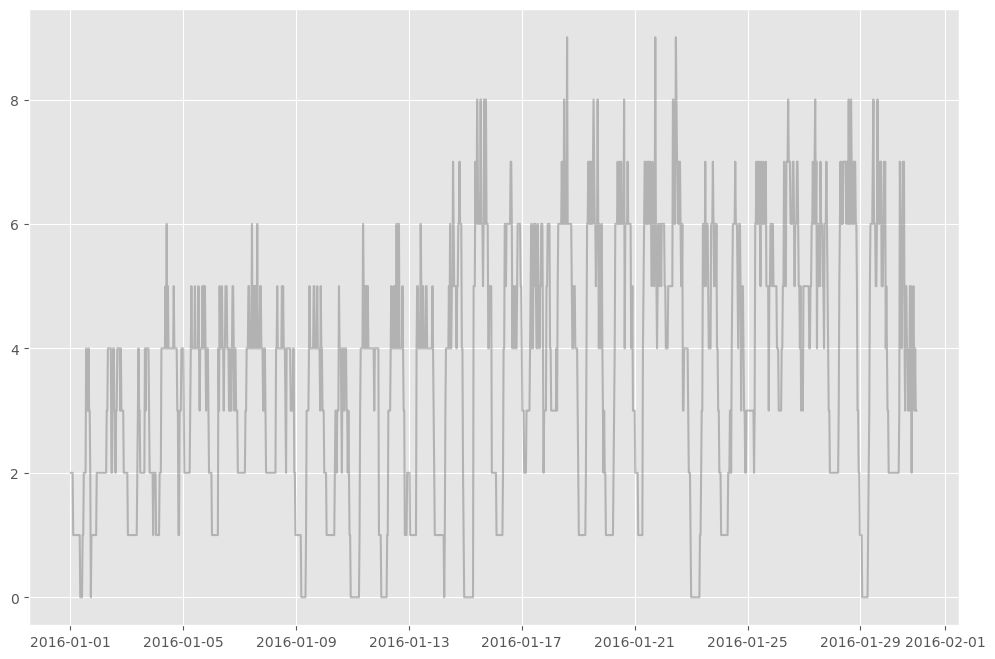

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

KeyboardInterrupt: 

In [31]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(df_sample.Period, df_sample.Sessions.values, label='Real Demand', color='grey', alpha=0.5)
plt.show()
for i in range((len(df_sample)-input_dim)//output_dim):
   X_train = df_sample.iloc[output_dim*i: input_dim + output_dim * i]
   y_train = df_sample.iloc[output_dim*i + input_dim: output_dim*(1+i) + input_dim]
   line1, = ax.plot(X_train.Period, X_train.Sessions.values, label=f'{i}', color='red', alpha=0.5)
   line2, = ax.plot(y_train.Period, y_train.Sessions.values, label=f'{i}', color='green', alpha=0.5)

   plt.draw()
   plt.pause(1)
   line1.remove()
   line2.remove()

In [32]:
poisson = torch.distributions.Poisson(1)

In [3]:
from losses import censored_poisson_negative_log_likelihood
import torch

In [4]:
y_pred = torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0])
y_true = torch.tensor([5.0, 5.0, 5.0, 5.0, 5.0])

censored_poisson_negative_log_likelihood(y_pred, y_true, 2)

tensor(4.8515, dtype=torch.float64)